In [1]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression


In [3]:
pip install seaborn


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  MedHouseVal  
0    -122.23        4.526  
1    -122.22        3.585  
2    -122.24        3.521  
3    -122.25        3.413  
4    -122.25        3.422  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population

c:\Users\abhin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Test RMSE: 0.7456
Test R²: 0.5758
5-fold CV R² scores: [0.54866323 0.46820691 0.55078434 0.53698703 0.66051406]
Mean CV R²: 0.5530311140279565


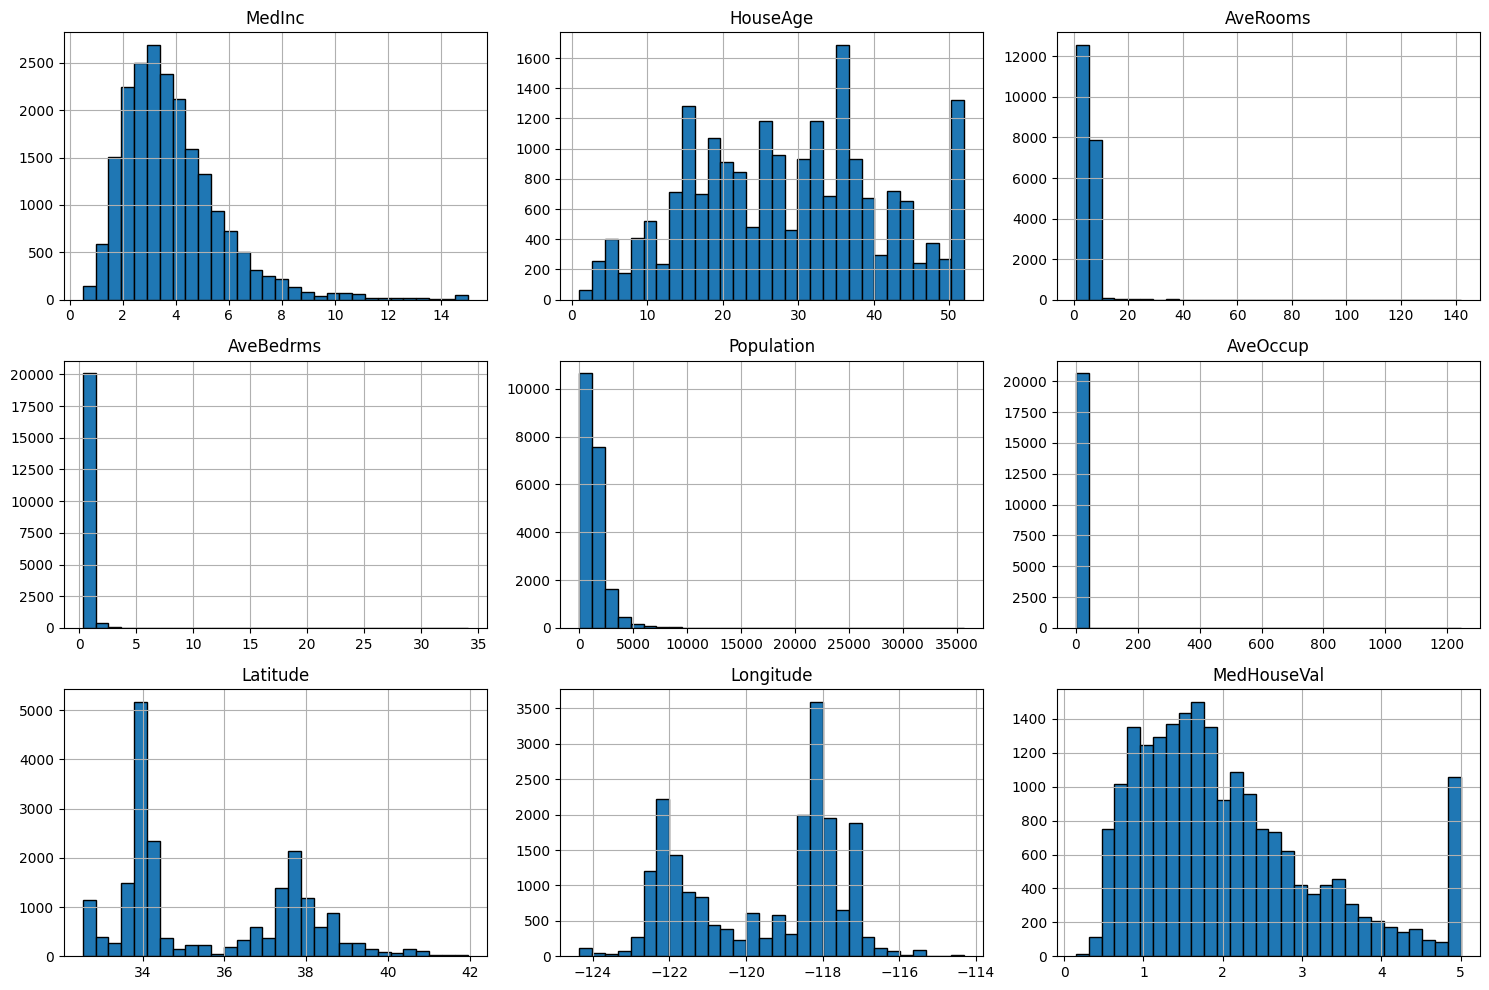

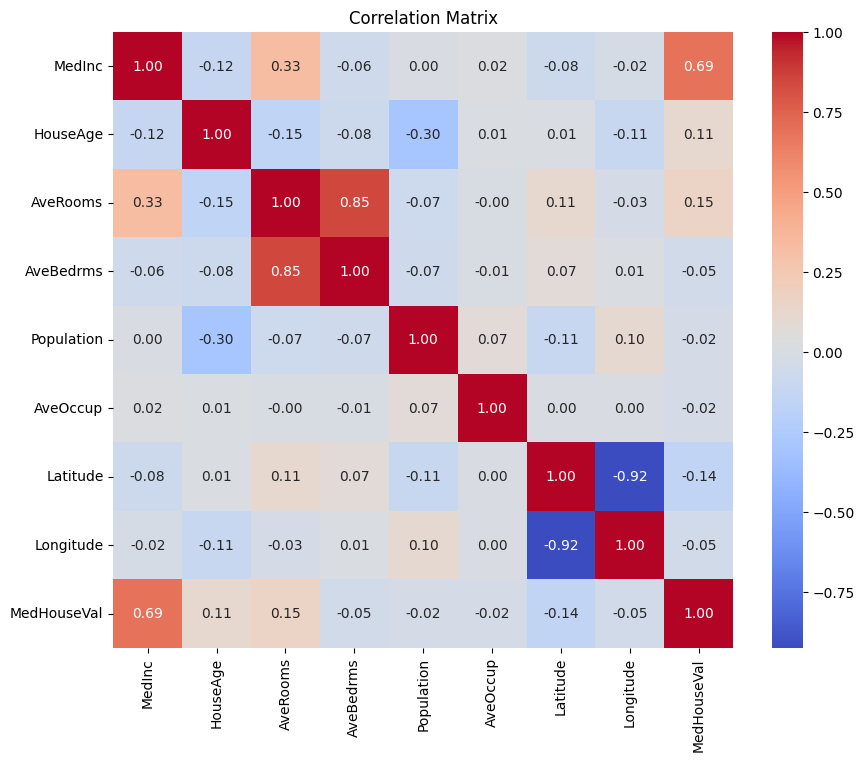

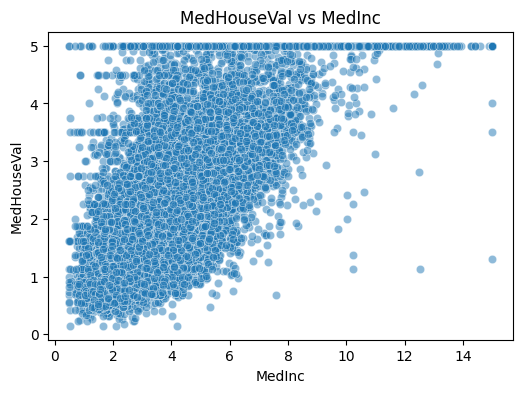

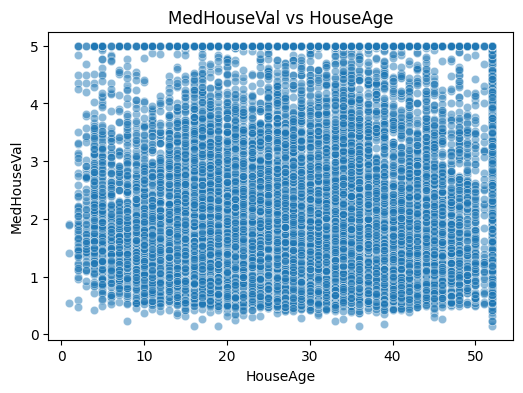

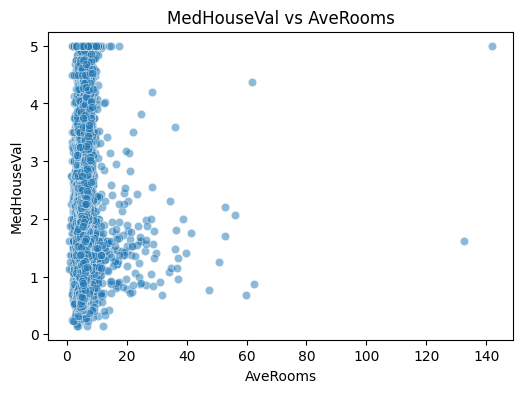

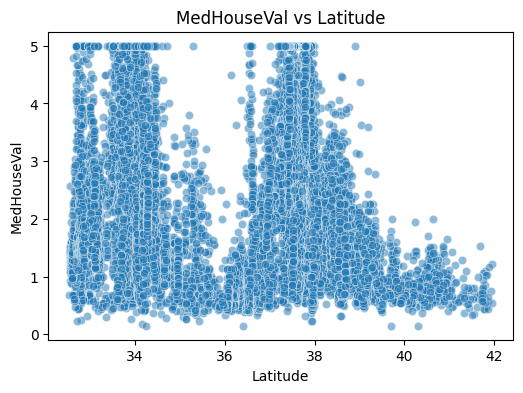

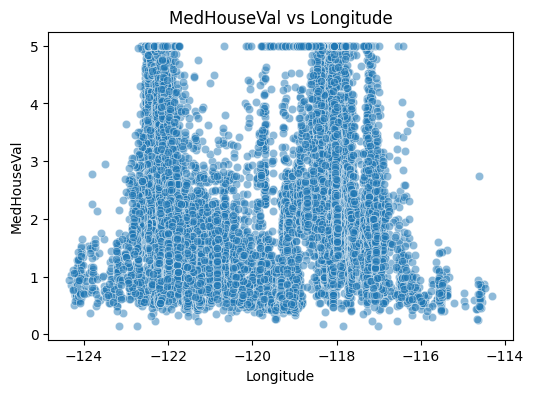

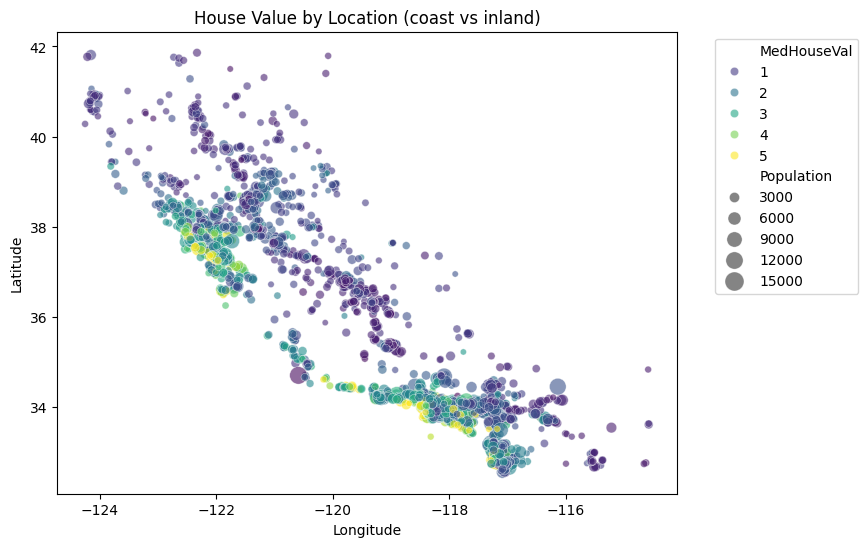

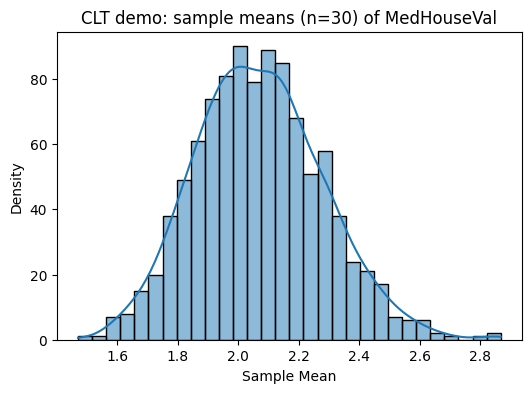

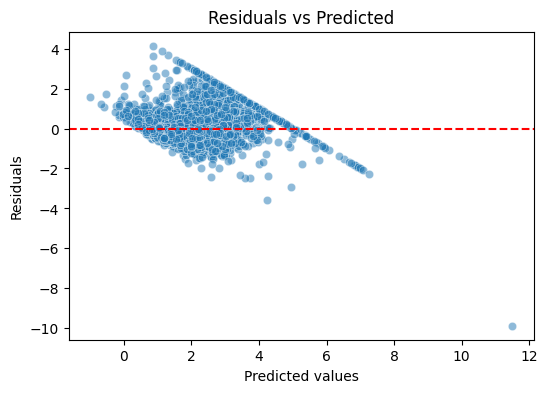

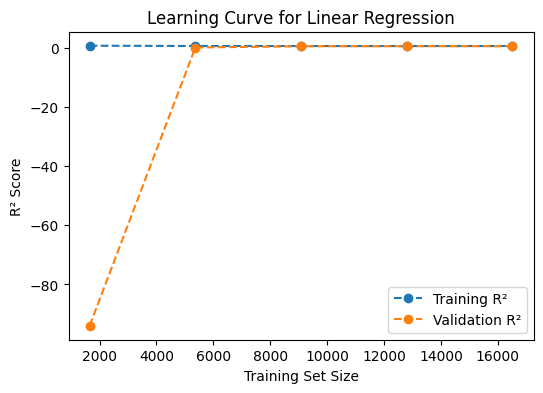

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score

# 1. Load data
housing = fetch_california_housing(as_frame=True)
df = housing.frame  # has data + target

# Optional: save
df.to_csv('data/california_housing.csv', index=False)

# 2. EDA
print(df.head())
print(df.info())
print(df.describe())

# Check missing values
print("Missing values per column:\n", df.isnull().sum())

# Distributions
df.hist(bins=30, figsize=(15,10), edgecolor='black')
plt.tight_layout()
plt.savefig('plots/hist_all_features.png')

# Correlation matrix
corr_mat = df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_mat, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.savefig('plots/corr_matrix.png')

# Scatter plots target vs important features
important = ['MedInc', 'HouseAge', 'AveRooms', 'Latitude', 'Longitude']
for feat in important:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=df[feat], y=df['MedHouseVal'], alpha=0.5)
    plt.xlabel(feat)
    plt.ylabel('MedHouseVal')
    plt.title(f'MedHouseVal vs {feat}')
    plt.savefig(f'plots/scatter_{feat}_vs_target.png')

# Geographical scatter
plt.figure(figsize=(8,6))
sns.scatterplot(data=df.sample(5000, random_state=42),
                x='Longitude', y='Latitude',
                hue='MedHouseVal', size='Population',
                palette='viridis', alpha=0.6, sizes=(20,200))
plt.title('House Value by Location (coast vs inland)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig('plots/geo_scatter.png')

# 3. CLT demo (sample means of target)
target = df['MedHouseVal'].values
n_samples = 1000
sample_size = 30
means = [target[np.random.randint(0, len(target), sample_size)].mean() for _ in range(n_samples)]
plt.figure(figsize=(6,4))
sns.histplot(means, bins=30, kde=True)
plt.title(f'CLT demo: sample means (n={sample_size}) of MedHouseVal')
plt.xlabel('Sample Mean')
plt.ylabel('Density')
plt.savefig('plots/clt_means.png')

# 4. Preprocessing, Train/Test split
X = df.drop(columns=['MedHouseVal'])
y = df['MedHouseVal']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Model training: Linear Regression with scaling
pipe = make_pipeline(StandardScaler(), LinearRegression())
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

# Metrics on test set
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
print(f"Test RMSE: {rmse:.4f}")
print(f"Test R²: {r2:.4f}")

# Residual plot
residuals = y_test - y_pred
plt.figure(figsize=(6,4))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted')
plt.savefig('plots/residuals_vs_predicted.png')

# 6. Cross-validation
cv_scores = cross_val_score(pipe, X, y, cv=5, scoring='r2')
print("5-fold CV R² scores:", cv_scores)
print("Mean CV R²:", cv_scores.mean())

# 7. Learning curve (bias-variance)
train_sizes, train_scores, test_scores = learning_curve(pipe, X, y, cv=5,
                                                        train_sizes=np.linspace(0.1,1.0,5),
                                                        scoring='r2', random_state=42)
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(6,4))
plt.plot(train_sizes, train_mean, 'o--', label='Training R²')
plt.plot(train_sizes, test_mean, 'o--', label='Validation R²')
plt.xlabel('Training Set Size')
plt.ylabel('R² Score')
plt.title('Learning Curve for Linear Regression')
plt.legend()
plt.savefig('plots/learning_curve.png')
